In [1]:
import torch
import scanpy as sc
import numpy as np
import scvi
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import muon
import mplscience
import poisson_atac as patac
import os

mplscience.available_styles()
mplscience.set_style(reset_current=True)
plt.rcParams['legend.scatterpoints'] = 1 

Global seed set to 0


['default', 'despine']


In [2]:
output_dir = "."

In [3]:
print(scvi.__version__)
print(sc.__version__)
print(muon.__version__)

0.17.1
1.9.1
0.1.2


In [4]:
adata = sc.read_h5ad("/lustre/groups/ml01/workspace/moscot_paper/pancreas/pancreas_multiome_2022_processed.h5ad")

In [5]:
adata = adata[:,adata.var["modality"]=="ATAC"].copy()

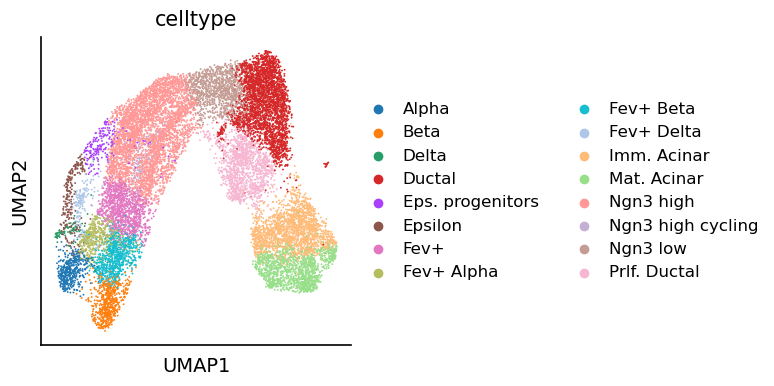

In [6]:
sc.pl.umap(adata, color=["celltype"])

# Poisson ATAC

In [7]:
n_peaks_before = adata.shape[1]

In [8]:
sc.pp.filter_genes(adata, min_cells=int(adata.shape[0]*0.02))

In [9]:
print(f"filtered {n_peaks_before - adata.n_vars} peaks.")

filtered 102443 peaks.


In [10]:
adata.layers["ATAC_counts"] = adata.X.copy()

In [11]:
adata.obs["batch"] = 1

In [12]:
patac.model.PoissonVI.setup_anndata(adata, layer="ATAC_counts", batch_key="batch")

In [13]:
poiss_vi = patac.model.PoissonVI(adata)


In [14]:
poiss_vi.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:385: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/500:  20%|████████▍                                 | 100/500 [15:59<1:03:57,  9.59s/it, loss=3.75e+04, v_num=1]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 37977.160. Signaling Trainer to stop.


<AxesSubplot:xlabel='epoch', ylabel='kl_global_train'>

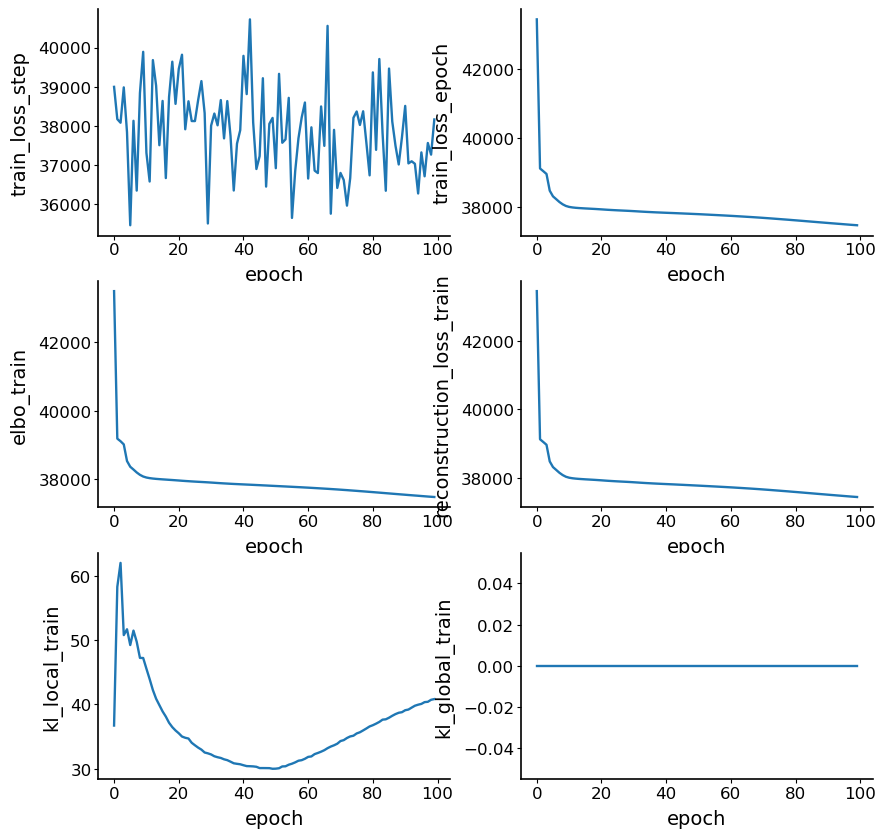

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))

sns.lineplot(data=poiss_vi.history['train_loss_step'], x="epoch", y="train_loss_step", ax=axs[0][0])
sns.lineplot(data=poiss_vi.history['train_loss_epoch'], x="epoch", y="train_loss_epoch", ax=axs[0][1])
sns.lineplot(data=poiss_vi.history['elbo_train'], x="epoch", y="elbo_train", ax=axs[1][0])
sns.lineplot(data=poiss_vi.history['reconstruction_loss_train'], x="epoch", y='reconstruction_loss_train', ax=axs[1][1])
sns.lineplot(data=poiss_vi.history['kl_local_train'], x="epoch", y='kl_local_train', ax=axs[2][0])
sns.lineplot(data=poiss_vi.history['kl_global_train'], x="epoch", y='kl_global_train', ax=axs[2][1])

In [16]:
adata.obsm["X_patac"]=poiss_vi.get_latent_representation()


In [17]:
adata

AnnData object with n_obs × n_vars = 16918 × 125816
    obs: 'n_counts', 'sample', 'n_genes', 'log_genes', 'mt_frac', 'rp_frac', 'ambi_frac', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'S_score', 'G2M_score', 'phase', 'proliferation', 'celltype', 'nCount_peaks', 'nFeature_peaks', 'batch', '_scvi_batch', '_scvi_labels'
    var: 'modality', 'n_cells'
    uns: 'celltype_colors', 'neighbors', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_pca', 'X_pca_wsnn', 'X_spca_wsnn', 'X_umap', 'X_umap_ATAC', 'X_umap_GEX', 'X_umap_wsnn', 'lsi_full', 'lsi_red', 'umap', 'umap_ATAC', 'umap_GEX', 'X_patac'
    layers: 'ATAC_counts'
    obsp: 'connectivities', 'connectivities_wnn', 'distances', 'distances_wnn'

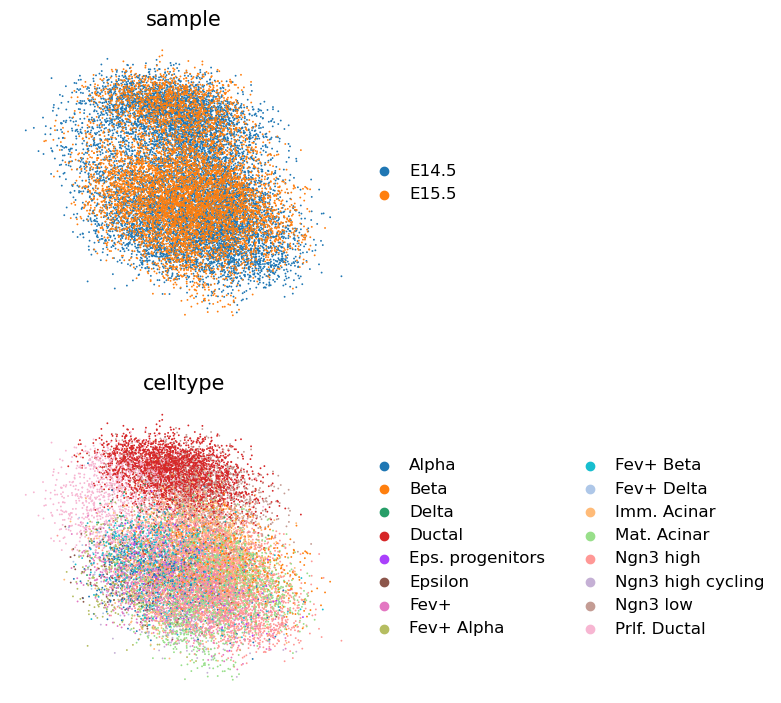

In [18]:
fig = sc.pl.embedding(
    adata,
    basis="X_patac",
    color=["sample", "celltype"],
    frameon=False,
    ncols=1,
    show=False,
)

In [19]:
sc.pp.neighbors(adata, use_rep="X_patac", key_added="patac")
sc.tl.umap(adata, neighbors_key="patac")

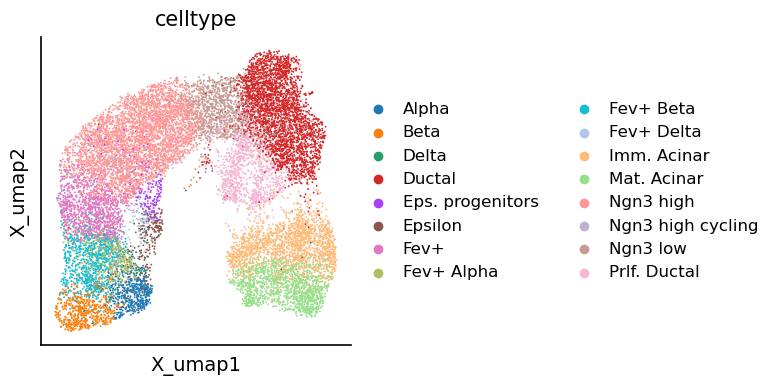

In [20]:
fig = sc.pl.embedding(adata, basis="X_umap", color="celltype", show=False)

In [21]:
fig.figure.savefig(os.path.join(output_dir, 'X_patac_umap_celltype.png'))

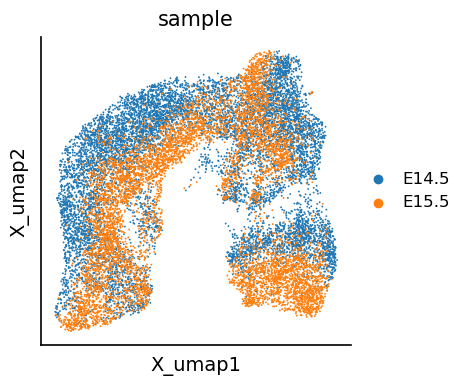

In [22]:
fig = sc.pl.embedding(adata, basis="X_umap", color="sample", show=False)

In [23]:
fig.figure.savefig(os.path.join(output_dir, 'X_patac_umap_sample.png'))

In [24]:
adata.obsm["X_patac_umap"] = adata.obsm["X_umap"].copy()

In [25]:
poiss_vi.save("/lustre/groups/ml01/workspace/moscot_paper/pancreas/embeddings/models/poissVI", overwrite=True, save_anndata=True)

# Poisson ATAC with batch correction

In [26]:
patac.model.PoissonVI.setup_anndata(adata, layer="ATAC_counts", batch_key="sample")

In [27]:
poiss_vi = patac.model.PoissonVI(adata)

In [28]:
poiss_vi.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:385: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 96/500:  19%|████████▍                                   | 96/500 [15:05<1:03:28,  9.43s/it, loss=3.76e+04, v_num=1]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 37976.258. Signaling Trainer to stop.


<AxesSubplot:xlabel='epoch', ylabel='kl_global_train'>

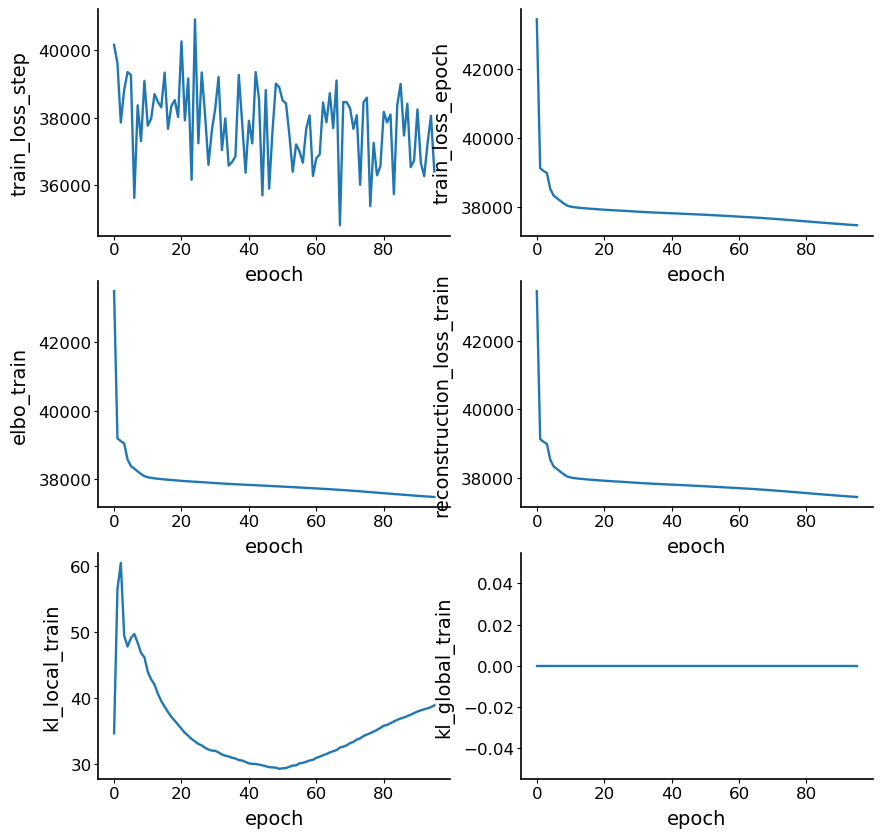

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))

sns.lineplot(data=poiss_vi.history['train_loss_step'], x="epoch", y="train_loss_step", ax=axs[0][0])
sns.lineplot(data=poiss_vi.history['train_loss_epoch'], x="epoch", y="train_loss_epoch", ax=axs[0][1])
sns.lineplot(data=poiss_vi.history['elbo_train'], x="epoch", y="elbo_train", ax=axs[1][0])
sns.lineplot(data=poiss_vi.history['reconstruction_loss_train'], x="epoch", y='reconstruction_loss_train', ax=axs[1][1])
sns.lineplot(data=poiss_vi.history['kl_local_train'], x="epoch", y='kl_local_train', ax=axs[2][0])
sns.lineplot(data=poiss_vi.history['kl_global_train'], x="epoch", y='kl_global_train', ax=axs[2][1])

In [30]:
adata.obsm["X_patac_batch_corrected"]=poiss_vi.get_latent_representation()

[<AxesSubplot:title={'center':'sample'}, xlabel='X_patac_batch_corrected1', ylabel='X_patac_batch_corrected2'>,
 <AxesSubplot:title={'center':'celltype'}, xlabel='X_patac_batch_corrected1', ylabel='X_patac_batch_corrected2'>]

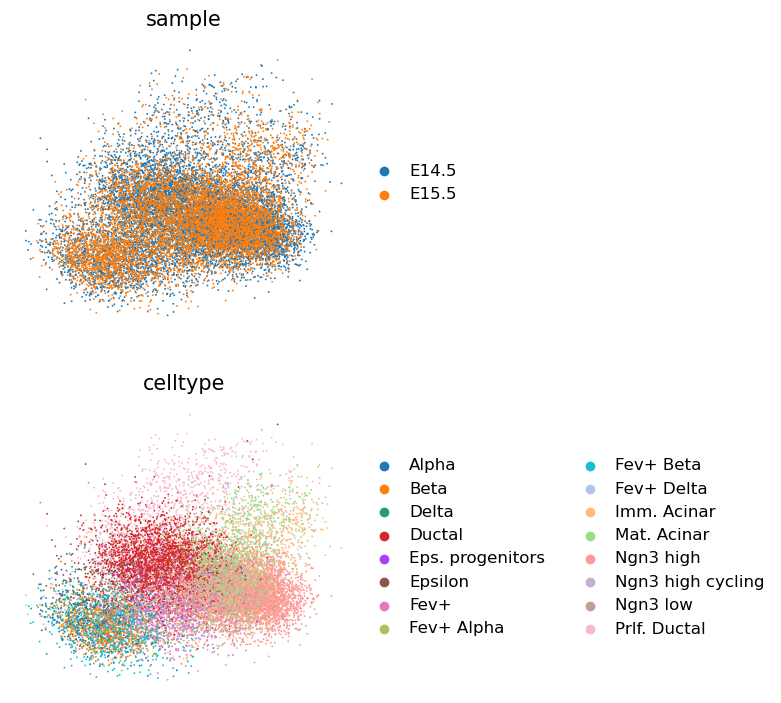

In [31]:
sc.pl.embedding(
    adata,
    basis="X_patac_batch_corrected",
    color=["sample", "celltype"],
    frameon=False,
    ncols=1,
    show=False
)

In [32]:
sc.pp.neighbors(adata, use_rep="X_patac_batch_corrected", key_added="patac")
sc.tl.umap(adata, neighbors_key="patac")

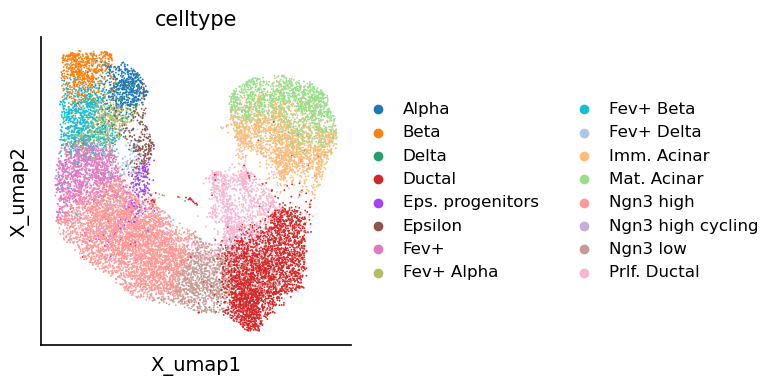

In [33]:
fig = sc.pl.embedding(adata, basis="X_umap", color="celltype", show=False)

In [34]:
fig.figure.savefig(os.path.join(output_dir, 'X_patac_umap_batch_corrected_celltype.png'))

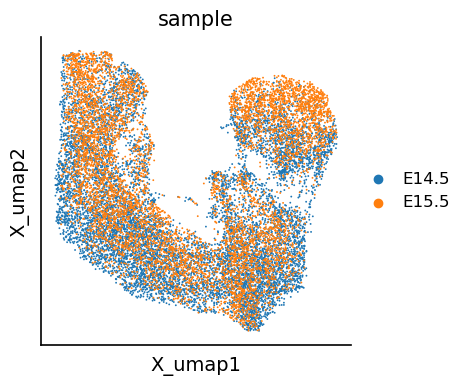

In [35]:
fig = sc.pl.embedding(adata, basis="X_umap", color="sample", show=False)

In [36]:
fig.figure.savefig(os.path.join(output_dir, 'X_patac_umap_batch_corrected_sample.png'))

In [37]:
adata.obsm["X_patac_batch_corrected_umap"] = adata.obsm["X_umap"].copy()

In [38]:
poiss_vi.save("/lustre/groups/ml01/workspace/moscot_paper/pancreas/embeddings/models/poissVI_batch_corrected", overwrite=True, save_anndata=True)

In [39]:
adata.write("/lustre/groups/ml01/workspace/moscot_paper/pancreas/embeddings/pancreas_ATAC_embeddings.h5ad")